## Make_More V3
#### Make Make_More even more powerfull
-we encounter the lowest dev loss of 2.17
- TO IMPROVE THE PERFORMENCE

- We can observe the intial loss of our model is very high, which we need to look into



In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
from networkx.classes import non_edges
from sympy import hermite_prob
from torch import nn
# from Transformers.NanoGPT import vocab_size
%matplotlib inline


In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
block_size = 3
context = [0] * block_size


def build_datasets(words):
    X , Y = [] , []

    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("X:" , X ,  "Y:" , Y)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(0)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_datasets(words[:n1])  # 80% of Xtr
Xdev, Ydev = build_datasets(words[n1:n2]) # 10%
Xte, Yte = build_datasets(words[n2:]) # 10%

print(f'Xtr: {Xtr.shape}, Ytr: {Ytr.shape}')
print(f'Xdev: {Xdev.shape}, Ydev: {Ydev.shape}')
print(f'Xte: {Xte.shape}, Yte: {Yte.shape}')



Xtr: torch.Size([182594, 3]), Ytr: torch.Size([182594])
Xdev: torch.Size([22846, 3]), Ydev: torch.Size([22846])
Xte: torch.Size([22706, 3]), Yte: torch.Size([22706])


In [8]:
print(Xtr.size(), Ytr.size(), Xte.size(), Yte.size())

torch.Size([182594, 3]) torch.Size([182594]) torch.Size([22706, 3]) torch.Size([22706])


<img src="Transformers/images/img.png">

In [12]:
# ------------- > lets make this more cleaner

<div >
<p>In order to decreace the intial loss we need to make our intial forward pass logits close to zero. </br>
To make it possible, (reduce the loss): lets try to reduce W2 to some fator of 0.01
 </br>
 and b1 to zeros </p>
</div>

In [9]:
n_embd = 10  # dimensionality of the character level embedding vectors
n_hidden = 200  # number of neurons in the hidden layer

g = torch.Generator().manual_seed(2323938434709) # for reproducibility
# look up table --> 2-10 (increasing embedding dim)
C = torch.rand(vocab_size, n_embd,                      generator=g)
# here (5/3)/(sqrt(fan_nodes))--- kaiming init for this weight initialization
W1 = torch.randn((n_embd*block_size, n_hidden),         generator=g)* (5/3)/((n_embd*block_size)**0.5)
# b1 = torch.randn(n_hidden,                              generator=g)*0.01
W2 = torch.randn((n_hidden, vocab_size),                generator=g)* 0.01
b2 = torch.randn(vocab_size,                            generator=g)* 0

# Batch Norm parameters
#--------------------------
bngain = torch.ones(1, n_hidden)
bnbias = torch.zeros(1, n_hidden)
#---------->># for single example input in inference----
bnmean_running = torch.zeros(1, n_hidden)
bnstd_running = torch.zeros(1, n_hidden)
# --------------------------------------------

parameters = [C, W1, W2, b2, bngain, bnbias]
print(f"Total_parameters :{sum(p.nelement() for p in parameters)}") # total num of parameters

for p in parameters:\
    p.requires_grad = True

Total_parameters :12097


In [11]:
# Training a Neural Net
epochs = 200000
batch_size = 32
lossi = []

for epoch in range(epochs):
    # Mini_batch Constructor------------------------
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X and Y

    # Forward pass ------------------------------------
    emb = C[Xb]  # (32, 3, 10)
    embcat = emb.view(emb.shape[0], -1) # concatenate vectors

    # Linear Layer before applying Non-linearity ------------
    hpreat = embcat @ W1  # + b1  # hiden layer pre activations

    # Batch Normalization Layer ------------------------
    bnmeani = hpreat.mean(0, keepdim= True)
    bnstdi = hpreat.std(0, keepdim=True)
    hpreat = bngain *(hpreat - bnmeani)/bnstdi + bnbias # we can add E for zero division error

    # Traking  bnmean and bnstd for inference ---------
    with torch.no_grad():
        bnmean_running = 0.999* bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999* bnstd_running + 0.001*bnstdi

    # Non- Linearity ---------------------------------------
    h = torch.tanh(hpreat)  # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward Pass ----------------------------------------
    for p in parameters:
        p.grad = None
    loss.backward()

    # update parameters --------------------------------------
    # lr = lrs[i]
    lr = 0.1 if epoch < 100000 else 0.01
    for p in parameters:
        learning_rate = -lr
        p.data += learning_rate * p.grad

    # tracking status -----------------------------------------
    # lri.append(lre[i])
    if epoch % 10000 ==0:
        print(f'epoch :{epoch:7d}/{epochs:7d}: loss {loss.item():.4f}')
    #
    lossi.append(loss.log10().item())



epoch :      0/ 200000: loss 3.2824
epoch :  10000/ 200000: loss 2.5701
epoch :  20000/ 200000: loss 2.4154
epoch :  30000/ 200000: loss 2.4425
epoch :  40000/ 200000: loss 1.9790
epoch :  50000/ 200000: loss 2.4864
epoch :  60000/ 200000: loss 1.8767
epoch :  70000/ 200000: loss 1.8811
epoch :  80000/ 200000: loss 2.1519
epoch :  90000/ 200000: loss 2.2956
epoch : 100000/ 200000: loss 2.2290
epoch : 110000/ 200000: loss 1.9589
epoch : 120000/ 200000: loss 2.3025
epoch : 130000/ 200000: loss 1.5771
epoch : 140000/ 200000: loss 2.0039
epoch : 150000/ 200000: loss 2.1351
epoch : 160000/ 200000: loss 1.9827
epoch : 170000/ 200000: loss 1.6170
epoch : 180000/ 200000: loss 2.0604
epoch : 190000/ 200000: loss 1.8893


## Overall Training loss

In [13]:
@torch.no_grad() # decorator helps to disable gradient traking during backward pass
def split_loss(split):
    x,y = {
        'train' : (Xtr,Ytr),
        'valid' : (Xdev,Ydev),
        'test' : (Xte,Yte),
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreat = embcat @ W1 # + b1
    hpreat = bngain *(hpreat - bnmean_running)/bnstd_running + bnbias
    h = torch.tanh(hpreat)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss :{loss.item()}')

split_loss("train")
split_loss("valid")

train loss :2.0677595138549805
valid loss :2.1182148456573486


In [1]:

# original:
# train 2.1245384216308594
# val 2.168196439743042

# fix softmax confidently wrong:
#
# train loss :2.0749599933624268
# valid loss :2.131558418273926
#
# fix tanh layer too saturated at init:
# train loss :2.069749116897583
# valid loss :2.118492603302002
#
# use semi-principled "kaiming init" instead of hacky init:
# train 2.0376641750335693
# val 2.106989622116089
#
# add batch norm layer
# train loss :2.069355010986328
#valid loss :2.1184942722320557


In [2]:
#-----------Pytorching the code--------------------

In [63]:
# -------Linear Layer -----------
class Linear:

    def __init__(self, in_features, out_features, bias=True):
        self.weight = torch.randn((in_features, out_features), generator=g)/ (in_features)**0.5
        self.bias = torch.zeros(out_features) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
# -------Batch Norm Layer -----------

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training =True
        # parameters (which are trained )
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trainned with momentum updating)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
          with torch.no_grad():
            self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
            self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
# ---- TanH layer =-------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


In [64]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147434123517) # for reproducibility

# network-------------------
C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
 Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    # making the last linear layer less confident
    layers[-1].gamma *=0.1
    # applying gain to other layers
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *=5/3 # kaiming init to stablize the activations

#_--------------Parameters------------------------
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

47024


In [65]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3252


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean -0.00, std 0.64, saturated: 2.44%
layer 8 (      Tanh): mean +0.01, std 0.65, saturated: 2.00%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 1.94%
layer 14 (      Tanh): mean +0.00, std 0.64, saturated: 1.75%


Text(0.5, 1.0, 'activation distribution')

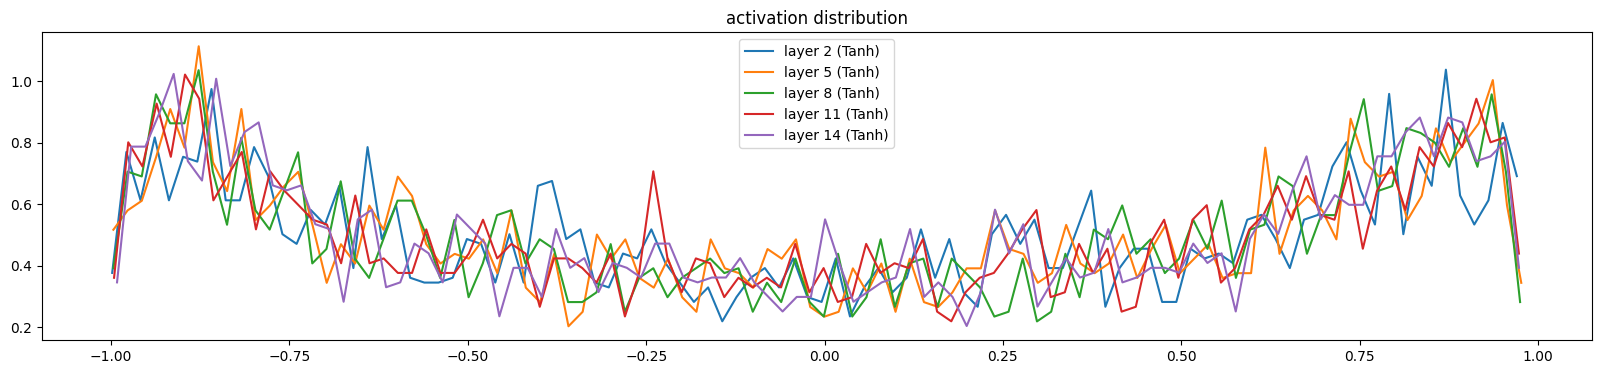

In [67]:
# Visualize the hist grams
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 8 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 11 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%
layer 14 (      Tanh): mean -0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

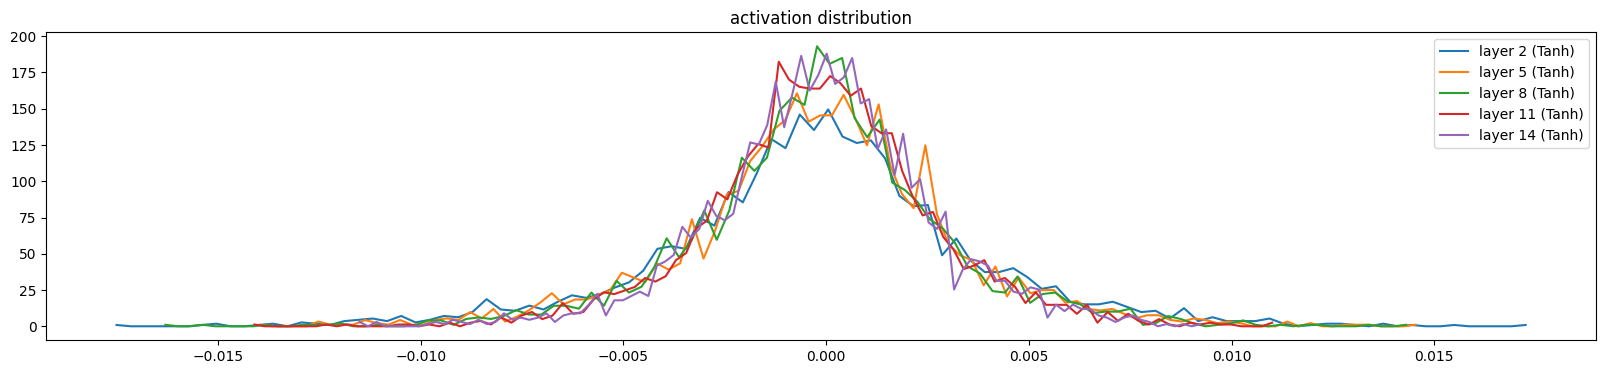

In [68]:
# Visualize the hist grams of gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title('activation distribution')

weight   (27, 10) | mean +0.000000 | std 1.101673e-02 | grad:data ratio 1.104636e-02
weight  (30, 100) | mean +0.000003 | std 9.382980e-03 | grad:data ratio 3.127784e-02
weight (100, 100) | mean -0.000006 | std 7.362085e-03 | grad:data ratio 4.401702e-02
weight (100, 100) | mean -0.000028 | std 6.846120e-03 | grad:data ratio 4.072953e-02
weight (100, 100) | mean +0.000056 | std 6.040449e-03 | grad:data ratio 3.595320e-02
weight (100, 100) | mean +0.000019 | std 5.982952e-03 | grad:data ratio 3.567766e-02
weight  (100, 27) | mean -0.000171 | std 1.145074e-02 | grad:data ratio 6.841380e-02


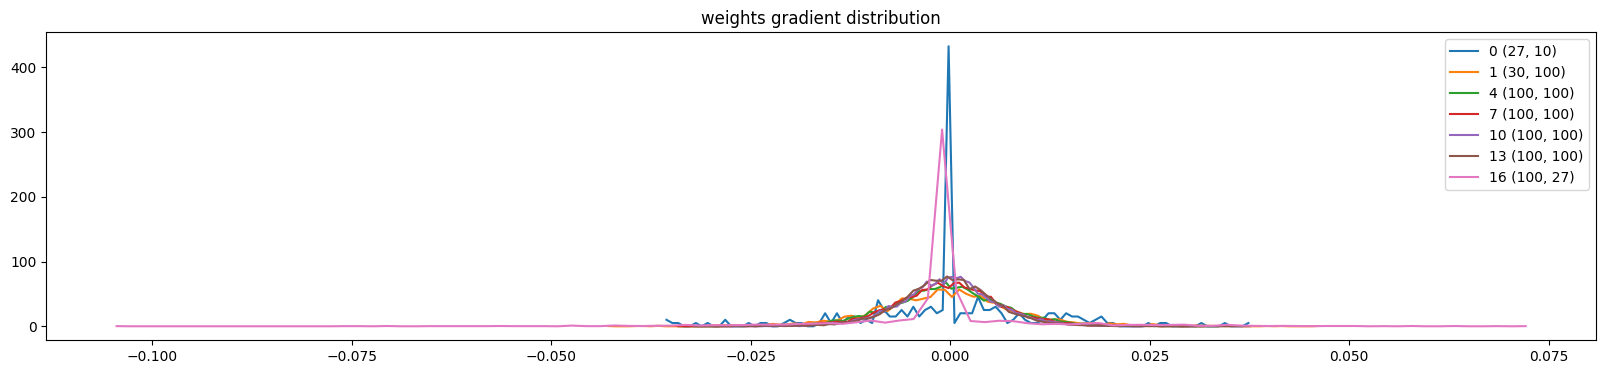

In [69]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

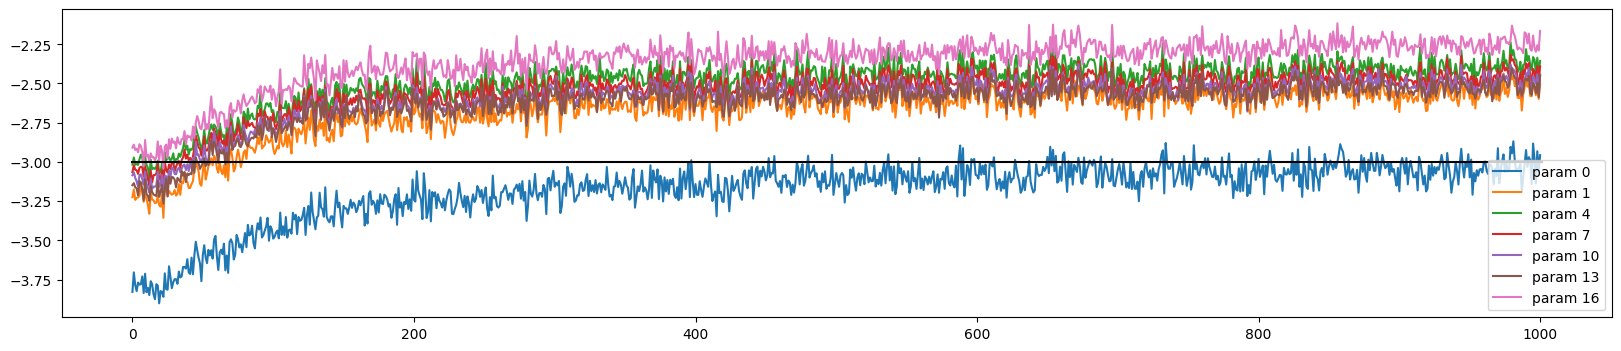

In [70]:
# update gradient to data ratio hist plot
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [120]:
# sample from the model
g = torch.Generator().manual_seed(2147483657)

for _ in range(20):
    out = []
    # intializing with all zeros [0,0,0] (...)
    context = [0] * block_size
    while True:
        # forward pass to the nerual network
        embed = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(embed.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sampling from the distribution using multinomial
        ix = torch.multinomial(probs, num_samples=1, generator=g)

        # shifting the context window ... ---> e ==> ..e --> m
        context = context[1:] + [ix]
        out.append(ix.item())
        # if the sample is special token (.) break
        if ix ==0:
            break
    # decoding the output embeddings
    print(''.join(itos[i] for i in out))

carmahzati.
havi.
kimrix.
taty.
hacaylie.
mahita.
deliah.
jarqui.
nellara.
chaiivon.
leigh.
ham.
pori.
quintis.
lilei.
jadiquoanthoniearynix.
kaelishuat.
emme.
iia.
gian.
